# week05_TimeSeries Project Temperature naiveModeling

In [109]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (12,6)

In [2]:
hb = pd.read_csv('ECA_blended_custom/TG_STAID000042.txt', sep =',', skiprows = 19)
list(hb.columns)

[' SOUID', '    DATE', '   TG', ' Q_TG']

In [3]:
hb.columns= ['SQUID', 'DATE', 'TG', 'Q_TG']
hb.head()
list(hb.columns)

['SQUID', 'DATE', 'TG', 'Q_TG']

In [ ]:
sns.heatmap(hb.isna())

In [4]:
hb['date'] = pd.to_datetime(hb['DATE'].astype(str), yearfirst = True)
hb['year'] = pd.to_datetime(hb['DATE'].astype(str), yearfirst = True).dt.year
hb['month'] = pd.to_datetime(hb['DATE'].astype(str), yearfirst = True).dt.month
hb['day'] = pd.to_datetime(hb['DATE'].astype(str), yearfirst = True).dt.day
hb['day_month'] = hb.day.astype(str) + "_" + hb.month.astype(str)
hb.set_index('date', inplace = True)
hb.head()

,SQUID,DATE,TG,Q_TG,year,month,day,day_month
date,,,,,,,,
1890-01-01,100138,18900101,-44,0,1890,1,1,1_1
1890-01-02,100138,18900102,-46,0,1890,1,2,2_1
1890-01-03,100138,18900103,-19,0,1890,1,3,3_1
1890-01-04,100138,18900104,25,0,1890,1,4,4_1
1890-01-05,100138,18900105,54,0,1890,1,5,5_1


In [5]:
hb['degree_celsius'] = hb['TG'] * 0.1
hb['Kelvin'] = hb['degree_celsius'] + 273.15
hb.head()

,SQUID,DATE,TG,Q_TG,year,month,day,day_month,degree_celsius,Kelvin
date,,,,,,,,,,
1890-01-01,100138,18900101,-44,0,1890,1,1,1_1,-4.4,268.75
1890-01-02,100138,18900102,-46,0,1890,1,2,2_1,-4.6,268.55
1890-01-03,100138,18900103,-19,0,1890,1,3,3_1,-1.9,271.25
1890-01-04,100138,18900104,25,0,1890,1,4,4_1,2.5,275.65
1890-01-05,100138,18900105,54,0,1890,1,5,5_1,5.4,278.55


In [ ]:
plt.plot(hb['TG'])

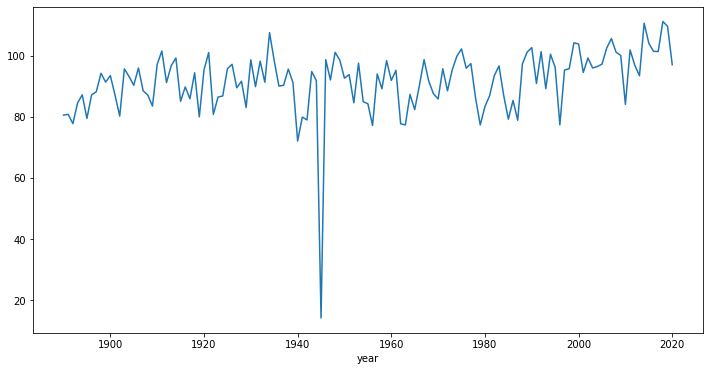

In [39]:
hb = hb.loc[hb['TG'] > -1000]
hb.groupby('year')['TG'].mean().plot()

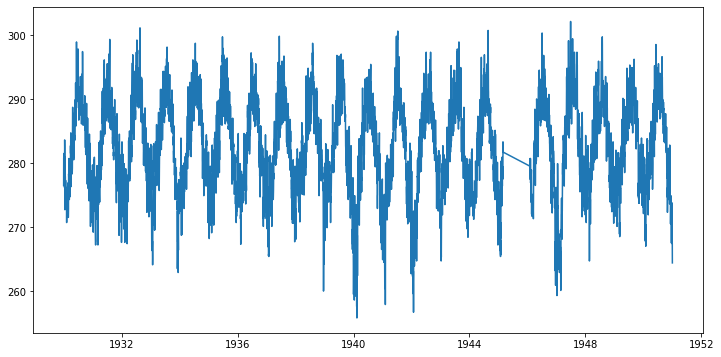

In [40]:
hb_1940 = hb['1930':'1950'] 
plt.plot(hb_1940['Kelvin'])

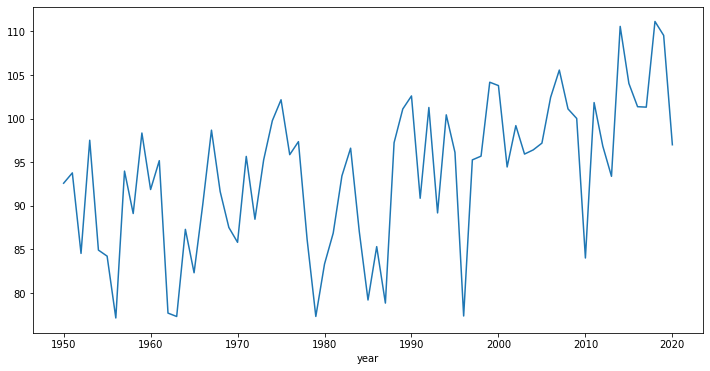

In [33]:
hb_clean = hb['1950':]
hb_clean.groupby('year')['TG'].mean().plot()

In [ ]:
hb_clean.tail()

In [ ]:
len(hb_clean.groupby('day_month'))

## split the data into training and testing dataset (last 12 month)

In [41]:
y_train = hb_clean['1950-07-01' :'2019-06-30' ].copy()
y_test = hb_clean['2019-07-01' : '2020-07-01'].copy()
y_train.shape, y_test.shape

((25202, 10), (366, 10))

In [50]:
# removing potential trends in the data
y_train['pct_change'] = y_train['Kelvin'].pct_change() 
# removing potential seasonality in the data by
# first calculate the mean of changes between 2 given days
y_train['daily_means'] = y_train.groupby('day_month')['pct_change'].transform('mean') 
# second calculating the differences of the daily percentage change minus the daily means of changes
y_train['deseasonalized'] = y_train['pct_change'] - y_train['daily_means']

,SQUID,DATE,TG,Q_TG,year,month,day,day_month,degree_celsius,Kelvin,pct_change,daily_means,deseasonalized
date,,,,,,,,,,,,,
1950-07-01,100138,19500701,166,0,1950,7,1,1_7,16.6,289.75,NaN,0.001389,NaN
1950-07-02,100138,19500702,164,0,1950,7,2,2_7,16.4,289.55,-0.000690,0.002428,-0.003118
1950-07-03,100138,19500703,163,0,1950,7,3,3_7,16.3,289.45,-0.000345,-0.000360,0.000014
1950-07-04,100138,19500704,153,0,1950,7,4,4_7,15.3,288.45,-0.003455,-0.000723,-0.002732
1950-07-05,100138,19500705,182,0,1950,7,5,5_7,18.2,291.35,0.010054,0.000667,0.009386


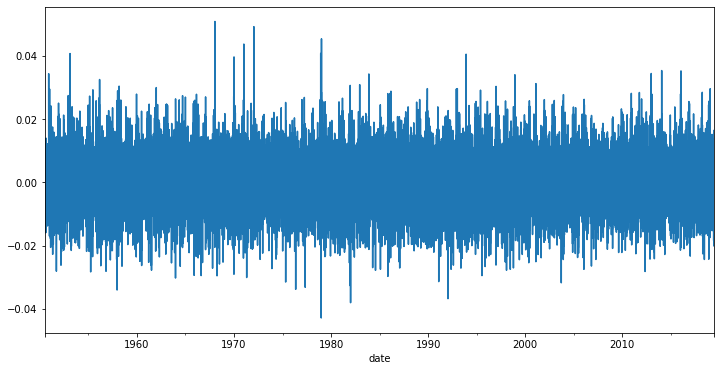

In [51]:
y_train['deseasonalized'].plot()

In [44]:
# as the startingpoint for predictions use the last observation in the data
last_observation = y_train['Kelvin'][-1]
last_observation

297.25

## reconstruct the prediction on the test data

In [52]:
# add the overall mean of temperature as a starting point
y_test['y_pred_mean'] = y_train['Kelvin'].mean()
# add the mean of the change in percentage to it
y_test['y_pred_mean_pct_change'] = y_train['pct_change'].mean()
# add the daily means of percentage chance over the whole time period to it
y_test['y_pred_daily_mean_pct'] = y_train['daily_means'][:366].values
y_test.head()

,SQUID,DATE,TG,Q_TG,year,month,day,day_month,degree_celsius,Kelvin,y_pred_mean,y_pred_mean_pct_change,y_pred_daily_mean_pct
date,,,,,,,,,,,,,
2019-07-01,100138,20190701,191,0,2019,7,1,1_7,19.1,292.25,282.494266,0.000034,0.001389
2019-07-02,100138,20190702,159,0,2019,7,2,2_7,15.9,289.05,282.494266,0.000034,0.002428
2019-07-03,100138,20190703,141,0,2019,7,3,3_7,14.1,287.25,282.494266,0.000034,-0.000360
2019-07-04,100138,20190704,159,0,2019,7,4,4_7,15.9,289.05,282.494266,0.000034,-0.000723
2019-07-05,100138,20190705,175,0,2019,7,5,5_7,17.5,290.65,282.494266,0.000034,0.000667


In [53]:
y_test['y_pred_daily_mean_pct'] += 1
y_test.head()

,SQUID,DATE,TG,Q_TG,year,month,day,day_month,degree_celsius,Kelvin,y_pred_mean,y_pred_mean_pct_change,y_pred_daily_mean_pct
date,,,,,,,,,,,,,
2019-07-01,100138,20190701,191,0,2019,7,1,1_7,19.1,292.25,282.494266,0.000034,1.001389
2019-07-02,100138,20190702,159,0,2019,7,2,2_7,15.9,289.05,282.494266,0.000034,1.002428
2019-07-03,100138,20190703,141,0,2019,7,3,3_7,14.1,287.25,282.494266,0.000034,0.999640
2019-07-04,100138,20190704,159,0,2019,7,4,4_7,15.9,289.05,282.494266,0.000034,0.999277
2019-07-05,100138,20190705,175,0,2019,7,5,5_7,17.5,290.65,282.494266,0.000034,1.000667


In [47]:
y_test['y_pred_daily_mean_pct'] = np.cumprod(y_test['y_pred_daily_mean_pct'])
y_test['y_pred_daily_mean_pct'] *= last_observation
y_test.head()

,SQUID,DATE,TG,Q_TG,year,month,day,day_month,degree_celsius,Kelvin,y_pred_mean,y_pred_mean_pct_change,y_pred_daily_mean_pct
date,,,,,,,,,,,,,
2019-07-01,100138,20190701,191,0,2019,7,1,1_7,19.1,292.25,282.494266,0.000034,297.662777
2019-07-02,100138,20190702,159,0,2019,7,2,2_7,15.9,289.05,282.494266,0.000034,298.385437
2019-07-03,100138,20190703,141,0,2019,7,3,3_7,14.1,287.25,282.494266,0.000034,298.278133
2019-07-04,100138,20190704,159,0,2019,7,4,4_7,15.9,289.05,282.494266,0.000034,298.062569
2019-07-05,100138,20190705,175,0,2019,7,5,5_7,17.5,290.65,282.494266,0.000034,298.261484


In [30]:
# Define a function that plots the forecast for us
def plot_forecast(y_train, y_test, columns):
    '''
    Plots forecasts of temperature
    
    Params:
    -------
    y_train: The training data
    y_test: The test data
    columns: Name of the prediction columns form a DataFrame
    
    '''
    # Plot the actual values
    y_train.Kelvin.plot(label='Training Data')
    y_test.Kelvin.plot(label=('Test Data'))
    
    # Plot each prediction
    for column in columns:
        y_test[column].plot(label=column)
    
    # General settings
    plt.title('Temperature per Day over Time', fontsize=15)
    plt.ylabel('Temperature in Kelvin', fontsize=12)
    plt.ylim(250,320)
    plt.xlabel('Date', fontsize=12)
    plt.legend()
    # plt.savefig('mean_baseline.png')
    plt.show()

In [48]:
y_train_short = y_train['2010':'2019']

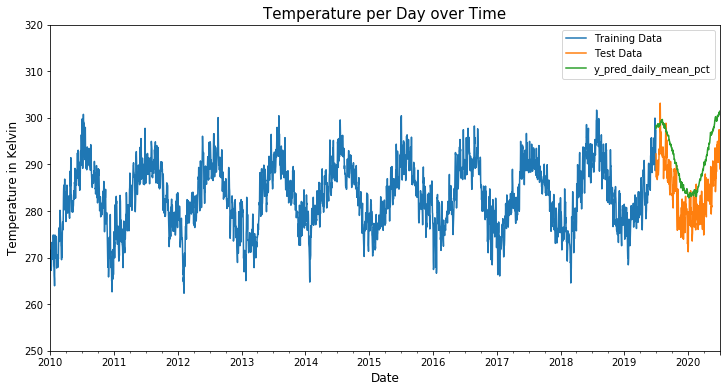

In [49]:
plot_forecast(y_train_short, y_test, ['y_pred_daily_mean_pct'])